# Install Librarires

# General Steps 
To import and prepare your data for analysis with machine learning models, focusing on VH (variable heavy chain) and VL (variable light chain) sequences along with their corresponding labels, follow these structured steps:

1. Import Libraries: Include necessary libraries for data manipulation (e.g., pandas), machine learning, and any specific libraries for handling VH and VL sequences, such as ablang and ablang2 for embedding generation.
2. Load Your Data: Use pandas or a similar library to load your dataset from a CSV file or another data source. This dataset should include VH and VL sequences and their corresponding labels indicating antigen neutralization.
3. Preprocess Data: Prepare the sequence data according to the input requirements of your pretrained models (ablang and ablang2). This might involve sequence cleaning, encoding, or formatting.
4. Load Pretrained Models: Initialize ablang and ablang2 models with pretrained weights, ready to generate embeddings for your sequences.
5. Generate Embeddings: Apply the pretrained models to your preprocessed VH and VL sequences to produce embeddings. These embeddings transform the sequence data into a numerical format suitable for machine learning analysis.
6. Prepare Final Dataset: Combine the generated embeddings with the corresponding labels into a final dataset. This dataset will serve as the input for subsequent machine learning tasks, such as classification or clustering.
7. Machine Learning Analysis: Use the prepared dataset to train machine learning models, evaluate their performance, and perform predictions or exploratory data analysis.

## VH (Variable Heavy) and VL (Variable Light)
Antibodies, also known as immunoglobulins, are Y-shaped molecules composed of two identical heavy chains and two identical light chains. Each chain consists of variable (V) and constant (C) regions. The variable regions of the heavy and light chains (VH and VL, respectively) are critical for the antibody's specificity because they contain the antigen-binding site. This site binds to specific parts of an antigen, called epitopes, allowing the antibody to recognize and bind to a vast array of pathogens.

## VHH (Single Domain Antibodies)
VHH refers to a special type of antibody fragment derived from heavy-chain-only antibodies (HcAbs) found in camelids (camels, llamas, and alpacas). Unlike conventional antibodies, HcAbs do not have light chains, so their antigen-binding site consists solely of the variable domain of the heavy chain (VHH). VHH antibodies, also known as nanobodies, are much smaller than regular antibodies, which allows them to reach and bind to hidden epitopes that are inaccessible to conventional antibodies. Their small size, high stability, solubility, and ease of production in microbial systems make VHH antibodies particularly attractive for research, diagnostic, and therapeutic applications.

VHorVHH seems to contain both heavy and light weight variables. ablang2_model requires both VH and VL as input sequences to conduct embedding.

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning / Data Processing libraries
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras import regularizers
import keras  

# Specialized libraries (assuming these are either third-party or local)
# import ablang  
import ablang2  
# import icn3dpy  

2024-08-07 13:33:08.144606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 13:33:09.208059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [482]:
df = pd.read_csv("data/CoV-AbDab_240208.csv")# 12k rows
df.head(5)

,Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,...,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
0,Curtis_3548_S-2,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,SARS-CoV2_WT (weak),NaN,S; RBD/non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,ARGSRNDLRDFDY,QSYNSSLSGLVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
1,Curtis_3548_S-7,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,AREPYSSGMGGRDY,QQYGSSPYT,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
2,Curtis_3548_RBD-15,Ab,SARS-CoV2_WT,SARS-CoV2_Beta;SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; iso-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,...,ND,AKGIYSSSSYWFGP,QAWDSSTVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Binds only non-prefusion stabilised RBD. Complete
3,8-D9,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells; SARS-CoV2 Human Vaccinee (BBIBP-CorV),VQLVESGGGLVQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLEW...,DIQMTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,...,IGKJ3 (Human),ARDHSGHALDI,QHLNSYPSMYT,https://www.rcsb.org/structure/8J1T;https://ww...,NaN,"Wanbo Tai et al., 2023 (https://www.nature.com...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
4,Sun_1G11,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron-BQ1;SARS-CoV2_Omicron-BQ1.1;...,S; RBD,B-cells; SARS-CoV2 Human Patient,EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...,...,IGKJ3 (Human),VKDSNYDSSGYLINNFDY,QQLYTFPVT,https://www.rcsb.org/structure/8IX3,NaN,"Hui Sun et al., 2023 (https://journals.asm.org...","Feb 8, 2024","Feb 8, 2024",NaN,Complete


In [487]:
# get the heavy chain sequence "seqs", the neutralising data (0 or 1) "neutralising", and PDB IDs "pdbids"
seqsvh = []
seqsvl = []
seqscdrh3 = []
seqscdrl3 = []
neutralising = []
pdbids = []

frame_size = len(df.index)
count = 0

# There are some problems in some sequences, still trying all 12k rows
#removed count for 3k
for i in range(frame_size):
    # Selecting Antibodies of Human Origin, with VH and VL data
    if (str(df.iloc[i]['Origin']).lower().find('human') != -1 and str(df.iloc[i]['Neutralising Vs']) != "nan" and str(df.iloc[i]['Not Neutralising Vs']) != "nan" and df.iloc[i]['VHorVHH'] != 'ND' and df.iloc[i]['VL'] != 'ND' 
        and (not pd.isnull(df.iloc[i]['VL'])) and df.iloc[i]['CDRH3'] != 'ND' and str(df.iloc[i]['CDRH3']).lower().find(' ') == -1 and df.iloc[i]['CDRL3'] != 'ND' and str(df.iloc[i]['Protein + Epitope']).lower().find(' rbd') != -1
        and (not pd.isnull(df.iloc[i]['CDRL3'])) and str(df.iloc[i]['CDRL3']).lower().find(' ') == -1):
        seqsvh.append(df.iloc[i]['VHorVHH'])
        seqsvl.append(df.iloc[i]['VL'])
        seqscdrh3.append(df.iloc[i]['CDRH3'])
        seqscdrl3.append(df.iloc[i]['CDRL3'])

        # Set neutralising to 1 of 0 depending on Neutralising Vs is not empty
        # somehow the empty string became "nan"
        if(str(df.iloc[i]['Neutralising Vs']) != "nan" and str(df.iloc[i]['Neutralising Vs']).lower().find('cov2') != -1):
            neutralising.append(1)
        else:
            neutralising.append(0)

        # DOES NOT DO ANYTHING
        if(str(df.iloc[i]['Structures']).find('PDB entry') != -1):
            pdbids.append(str(df.iloc[i]['Structures'])[10:14])
            count = count +1
        else:
            pdbids.append('')
            
print ("Lines:", len(seqsvh))
print (seqsvh[0:2])
print (seqsvl[0:2])
print (seqscdrh3[0:2])
print (seqscdrl3[0:2])
print (neutralising[0:2])
print (pdbids[0:2])
print (count)

Lines: 1690
['EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLEWVSGTSWNSGTTGYADSVRGRFTISRDNAKKSLYLQMNSLGVEDTAFYYCVKDSNYDSSGYLINNFDYWGQGILVTVSS', 'EVQLVESGGGLVQPGRSLRVSCAASGFTFDDYAMHWVRQTPRKGLEWVAGISRNSAAIAYADSVKGRFTISRDNAKNSVFLQMNGLRADDTALYYCVKSPRYGWGSPDYSFDFWGRGTLVTVSA']
['DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKVLIYAASTLHSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQLYTFPVTFGPGTKVDVR', 'EIQLTQSPSSLSASVGDRVTITCRASQNIGTYLNWYQQEPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYCCQQSFTTPLTFGQGTKVEIK']
['VKDSNYDSSGYLINNFDY', 'VKSPRYGWGSPDYSFDF']
['QQLYTFPVT', 'QQSFTTPLT']
[1, 1]
['', '']
0


# Data exploration
First we can compare the distibution of those data related to binidng and non binding and see if there is a different between them
We can use simple box plot or even PC to check it.

In [488]:
df = pd.DataFrame({'seqsvh': seqsvh, 'seqsvl':seqsvl, 'neutralising': neutralising})
df2 = pd.DataFrame({'seqscdrh3': seqscdrh3, 'seqscdrl3':seqscdrl3, 'neutralising': neutralising})
print(df.head())
df2.head()

                                              seqsvh  \
0  EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...   
1  EVQLVESGGGLVQPGRSLRVSCAASGFTFDDYAMHWVRQTPRKGLE...   
2  QVQLVQSGAEVKKPGESLMISCKASGYNFRNYWIAWVRQMPGKGLE...   
3  EVQLVESGGGLVQPGGSLRLSCAASGLLVSRNYMNWVRQAPGKGLE...   
4  EVQLVESGGGLVPPGGSLRLSCAASGFIFSNYAMTWVRQAPGKGLE...   

                                              seqsvl  neutralising  
0  DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...             1  
1  EIQLTQSPSSLSASVGDRVTITCRASQNIGTYLNWYQQEPGKAPKL...             1  
2  EIVLTQSPSTLSASVGDRVTITCRASQNIYTWLAWYQRKPGKAPKV...             1  
3  ELTQPLSVSMALGQTARISCGGDNVGSQNVHWYQQRPGQAPVLVIY...             1  
4  DIVMTQSPDSLAVSLGERATINCKSSQSVLYSSNNKNYLAWYQQKP...             1  


,seqscdrh3,seqscdrl3,neutralising
0,VKDSNYDSSGYLINNFDY,QQLYTFPVT,1
1,VKSPRYGWGSPDYSFDF,QQSFTTPLT,1
2,TRITTDADSSGLFHY,QQYKSAWS,1
3,ARDLSDYGGIDC,QVWDSSTVA,1
4,AKDLFGSGWSLFDN,QQYYSPPIT,1


count    1690.000000
mean        0.926036
std         0.261791
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: neutralising, dtype: float64
count    1690.000000
mean        0.926036
std         0.261791
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: neutralising, dtype: float64
neutralising
1    1565
0     125
Name: count, dtype: int64
neutralising
1    1565
0     125
Name: count, dtype: int64


<Axes: >

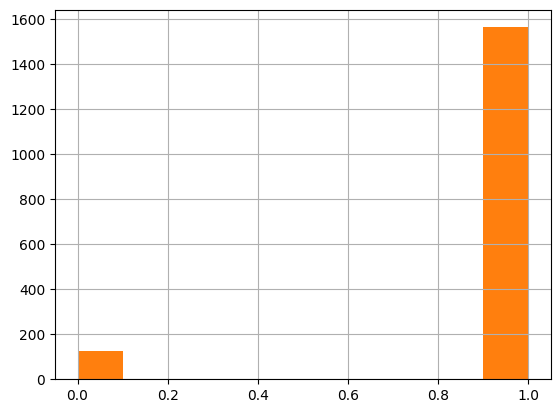

In [489]:
# Summary statistics for the neutralising column
print(df['neutralising'].describe())
print(df2['neutralising'].describe())

# Count the distribution of the 'neutralising' labels
print(df['neutralising'].value_counts())
df['neutralising'].hist()

print(df2['neutralising'].value_counts())
df2['neutralising'].hist()

array([[<Axes: title={'center': 'seqscdrh3_length'}>,
        <Axes: title={'center': 'seqscdrl3_length'}>]], dtype=object)

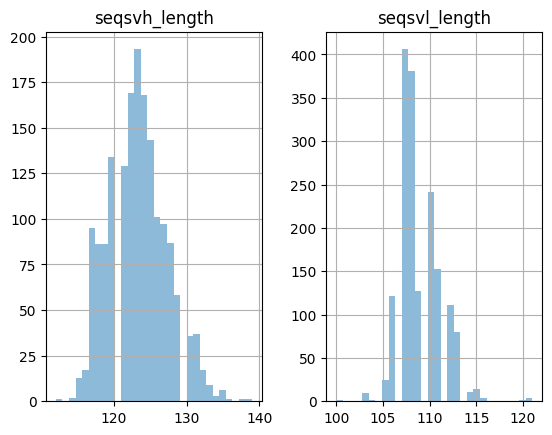

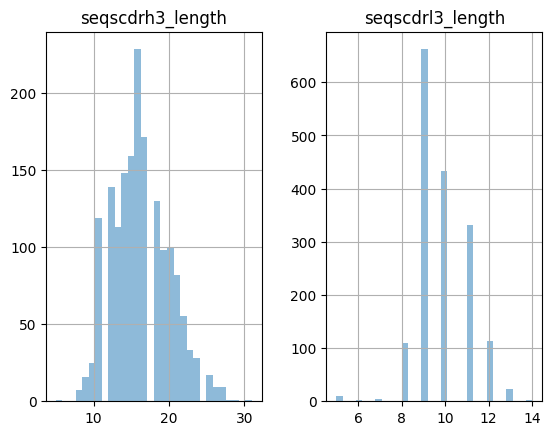

In [490]:
# Calculate and plot the distribution of sequence character lengths for VH and VL
df['seqsvh_length'] = df['seqsvh'].apply(len)
df['seqsvl_length'] = df['seqsvl'].apply(len)

df2['seqscdrh3_length'] = df2['seqscdrh3'].apply(len)
df2['seqscdrl3_length'] = df2['seqscdrl3'].apply(len)

# Plotting
df[['seqsvh_length', 'seqsvl_length']].hist(bins=30, alpha=0.5)
df2[['seqscdrh3_length', 'seqscdrl3_length']].hist(bins=30, alpha=0.5)

In [491]:
# Example: Frequency of amino acids in 'seqsvh'
# This is a more complex analysis, depending on your needs. Here's a simplified approach:

# Function - counts frequency of each amino acid (letter) in each VH string
def amino_acid_frequency(sequence):
    return pd.Series(list(sequence)).value_counts(normalize=True)

# Apply the function to a small sample for demonstration
sample_freqs_vh = df2['seqscdrh3'].apply(amino_acid_frequency)

# Print average frequencies across small sample
print(sample_freqs_vh.mean())

# Check if there are 20 amino acids
print(sample_freqs_vh.mean().size)

D    0.127892
S    0.103946
N    0.071365
Y    0.139691
V    0.095069
K    0.065275
G    0.125342
L    0.088922
I    0.074564
F    0.087613
P    0.082684
R    0.088961
W    0.070966
T    0.087841
A    0.106476
H    0.072031
C    0.103318
E    0.075765
Q    0.068691
M    0.069064
dtype: float64
20


In [492]:
# Simple correlations between sequence lengths and neutralising status
print(df[['seqsvh_length', 'seqsvl_length', 'neutralising']].corr())
print(df2[['seqscdrh3_length', 'seqscdrl3_length', 'neutralising']].corr())

               seqsvh_length  seqsvl_length  neutralising
seqsvh_length       1.000000       0.158466      0.019309
seqsvl_length       0.158466       1.000000      0.085277
neutralising        0.019309       0.085277      1.000000
                  seqscdrh3_length  seqscdrl3_length  neutralising
seqscdrh3_length          1.000000          0.140335      0.020351
seqscdrl3_length          0.140335          1.000000     -0.009564
neutralising              0.020351         -0.009564      1.000000


Text(0.5, 1.0, 'Sequence Length Distribution')

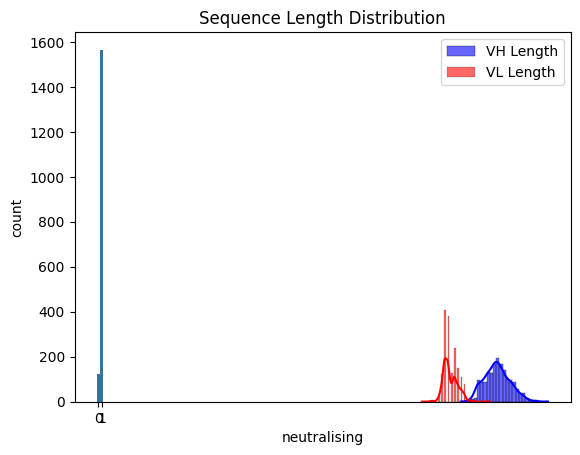

In [493]:
# Class balance
sns.countplot(x='neutralising', data=df)
plt.title('Class Distribution')

# Sequence length distribution
sns.histplot(data=df, x='seqsvh_length', color='blue', kde=True, label='VH Length', alpha=0.6)
sns.histplot(data=df, x='seqsvl_length', color='red', kde=True, label='VL Length', alpha=0.6)
plt.legend()
plt.title('Sequence Length Distribution')

# Embedding 
Loading a pretrained model to perform embedding on antibody sequences involves converting the string representation of these sequences (which consists of amino acid characters) into a numerical format that machine learning models can process. 

- How Embedding Works
Pretrained Models: A pretrained model, such as ablang or ablang2 mentioned earlier, is typically a deep learning model that has been previously trained on a large dataset of antibody sequences. During its training, the model learns to capture the complex patterns and relationships between the amino acids in these sequences, effectively understanding the biological significance behind different sequence motifs and structures.

- Sequence to Numerical Representation: When you pass an antibody sequence to such a pretrained model, the model processes the sequence and converts it into a high-dimensional vector (or array) of numbers. This vector is called an "embedding". The embedding process captures the essential features of the sequence, such as the presence of certain motifs or the overall sequence structure, in a form that is useful for further computational analysis.

## Ablang 

In [494]:
# heavy chain sequence
# heavy_ablang = ablang.pretrained("heavy")
# heavy_ablang.freeze()

In [495]:
# use the "Seq-coding" example to get an array for each sequence
# seqcodings = heavy_ablang(seqs, mode='seqcoding')

## Ablang2

Note: VHorVHH seems contain both heavy and light weight variable. ablang2_model reuires both VH and VL as input sequence to conduct embedding.

In [496]:
# load Ablang2 model to create embedding the sequence
ablang2_model = ablang2.pretrained()

/opt/jupyterhub/lib/python3.10/site-packages/ablang2/load_model.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [497]:
# Ablang2 data format [VH sequence, VL sequence]
# Test the model embedding
seq1 = [
    'EVQLLESGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCARDVPGHGAAFMDVWGTGTTVTVSS', # VH sequence
    'DIQLTQSPLSLPVTLGQPASISCRSSQSLEASDTNIYLSWFQQRPGQSPRRLIYKISNRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK' # VL sequence
]
seq2 = [
    'EVQLLESGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCARDVPGHGAAFMDVWGTGTT',
    'PVTLGQPASISCRSSQSLEASDTNIYLSWFQQRPGQSPRRLIYKISNRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK'
]
seq3 = [
    'EVQLLESGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCARDVPGHGAAFMDVWGTGTTVTVSS',
    '' # The VL sequence is not known, so an empty string is left instead. 
]
seq4 = [
    '',
    'DIQLTQSPLSLPVTLGQPASISCRSSQSLEASDTNIYLSWFQQRPGQSPRRLIYKISNRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK'
]
seq5 = [
    'EVQ***SGGEVKKPGASVKVSCRASGYTFRNYGLTWVRQAPGQGLEWMGWISAYNGNTNYAQKFQGRVTLTTDTSTSTAYMELRSLRSDDTAVYFCAR**PGHGAAFMDVWGTGTTVTVSS', # (*) is used to mask certain residues
    'DIQLTQSPLSLPVTLGQPASISCRSS*SLEASDTNIYLSWFQQRPGQSPRRLIYKI*NRDSGVPDRFSGSGSGTHFTLRISRVEADDVAVYYCMQGTHWPPAFGQGTKVDIK'
]

all_seqs = [seq1, seq2, seq3, seq4, seq5]
only_both_chains_seqs = [seq1, seq2, seq5]
encoded = ablang2_model(all_seqs, mode='seqcoding')
print(encoded)

[[-0.25206308  0.18189639  0.00887142 ...  0.15365519 -0.14508601
  -0.13381318]
 [-0.25149422  0.20864549  0.07518206 ...  0.19478266 -0.15227777
  -0.08241647]
 [-0.2746895   0.16507227  0.08667147 ...  0.18776285 -0.1416508
  -0.16389884]
 [-0.19822132  0.16841077 -0.0492593  ...  0.11400159 -0.1472369
  -0.09713167]
 [-0.29553183  0.17239198  0.05676916 ...  0.15943628 -0.16615374
  -0.1556978 ]]


In [498]:
# Add new col to data frame 'seq' that combines vh and vl to prep for ablang2

df['seq'] = df.apply(lambda row: [row['seqsvh'], row['seqsvl']], axis=1)
df2['seq'] = df2.apply(lambda row: [row['seqscdrh3'], row['seqscdrl3']], axis=1)
print(df)

                                                 seqsvh  \
0     EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...   
1     EVQLVESGGGLVQPGRSLRVSCAASGFTFDDYAMHWVRQTPRKGLE...   
2     QVQLVQSGAEVKKPGESLMISCKASGYNFRNYWIAWVRQMPGKGLE...   
3     EVQLVESGGGLVQPGGSLRLSCAASGLLVSRNYMNWVRQAPGKGLE...   
4     EVQLVESGGGLVPPGGSLRLSCAASGFIFSNYAMTWVRQAPGKGLE...   
...                                                 ...   
1685  EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLE...   
1686  QVQLQESGPGLVKPSETLSLTCSVSGDSISSSDYSWGWIRQPPGKG...   
1687  EVQLVQSGPEVKKPGTSVKVACKASGFTFITPVSMQWVRQARGQRL...   
1688  EVQLVESGGGVVQPGTSLRLSCAASGFSFSHYVMYWVRQAPGKGLD...   
1689  EVQLVESGAEVRKPGASVKLSCKASGYTFTSYYIHWVRQAPGQGLE...   

                                                 seqsvl  neutralising  \
0     DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...             1   
1     EIQLTQSPSSLSASVGDRVTITCRASQNIGTYLNWYQQEPGKAPKL...             1   
2     EIVLTQSPSTLSASVGDRVTITCRASQNIYTWLAWYQRKPGKAPKV...             1   

In [499]:
# Making new lists of each col in df

seqs = list(df['seq'])
seqsvh_list = [[item, ''] for item in seqsvh]
seqsvl_list = [['', item] for item in seqsvl]

seqs2 = list(df2['seq'])
seqscdrh3_list = [[item, ''] for item in seqscdrh3]
seqscdrl3_list = [['', item] for item in seqscdrl3]


In [500]:
# Checking if any values left in seqvl are not strings?

non_string_values = [item for item in seqsvl if not isinstance(item, str)]
non_string_values = [item for item in seqscdrl3 if not isinstance(item, str)]
non_string_values

[]

In [501]:
# Prepare the sequence in a format that can be read by ablang2 model

seqcodings = ablang2_model(seqs, mode='seqcoding')
print("The output shape of the seq-codings:", seqcodings.shape)
print(seqcodings)



The output shape of the seq-codings: (1690, 480)
[[-2.28510102e-01  7.74609190e-02  6.50437743e-02 ...  1.90456431e-01
  -1.62673095e-01 -1.82273901e-01]
 [-2.07794102e-01  2.17854619e-02 -2.07723565e-02 ...  1.36803720e-01
  -1.41048996e-01 -1.51990932e-01]
 [-2.25419022e-01  1.10453088e-01  2.73195769e-04 ...  2.25193878e-01
  -1.13672853e-01 -1.36326726e-01]
 ...
 [-3.16254630e-01  1.64208715e-01  7.73916668e-02 ...  2.32251136e-01
  -1.43328049e-01 -2.77589110e-01]
 [-2.62015331e-01  1.63625387e-01  1.01044493e-02 ...  1.78006818e-01
  -1.36622350e-01 -1.90165488e-01]
 [-2.65089276e-01  1.29088738e-01  9.04341306e-02 ...  1.60604693e-01
  -1.69738930e-01 -1.84766398e-01]]


In [502]:
seqcodings2 = ablang2_model(seqs2, mode='seqcoding')
print("The output shape of the seq2-codings:", seqcodings2.shape)
print(seqcodings2)

The output shape of the seq2-codings: (1690, 480)
[[-0.02564635 -0.02772845 -0.3015235  ...  0.45250145 -0.25867086
   0.13144823]
 [-0.09786073 -0.15210555 -0.26802458 ...  0.4906347  -0.20781165
   0.10053159]
 [-0.09563397 -0.16121997 -0.37634224 ...  0.34094099 -0.27614301
   0.17784054]
 ...
 [ 0.00364362 -0.12818822 -0.26337447 ...  0.32736662 -0.01551221
   0.0058412 ]
 [-0.09965214 -0.23961853 -0.29810921 ...  0.37713164 -0.21047244
   0.22448062]
 [-0.05386573  0.0014895  -0.32013885 ...  0.37828905 -0.18918964
   0.2263079 ]]


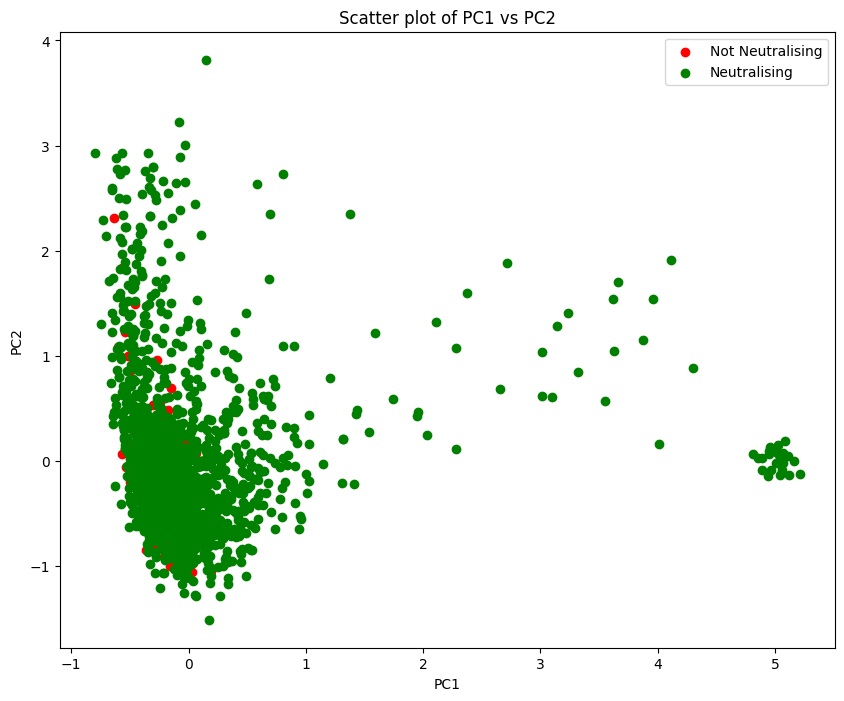

In [503]:
# Perform Principle Component Analysis (PCA) with the desired number of components (let's say 2 components for visualization)
# reduces dimensions from 480 to 2.
num_components = 2
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(seqcodings)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i + 1}' for i in range(num_components)])

# # Add the neutralising columns back to the PCA DataFrame
pca_df['neutralising'] = neutralising

# # Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'][pca_df['neutralising'] == 0], pca_df['PC2'][pca_df['neutralising'] == 0], color='r', label='Not Neutralising')
plt.scatter(pca_df['PC1'][pca_df['neutralising'] == 1], pca_df['PC2'][pca_df['neutralising'] == 1], color='g', label='Neutralising')
plt.title('Scatter plot of PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [504]:
pca_df.head()

,PC1,PC2,neutralising
0,-0.521780,0.852924,1
1,-0.283267,-0.875864,1
2,-0.539624,0.150495,1
3,-0.321816,-0.136648,1
4,0.040530,-0.375077,1


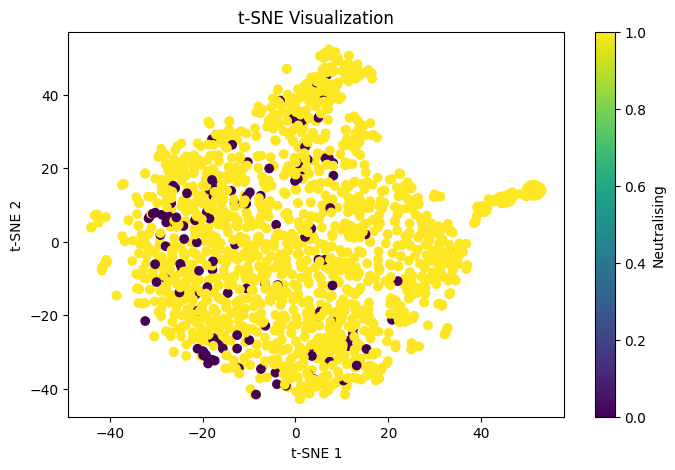

In [505]:
# Perform t-SNE (alternative to PCA)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(seqcodings)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['neutralising'], cmap='viridis')
plt.colorbar(label='Neutralising')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization')
plt.show()

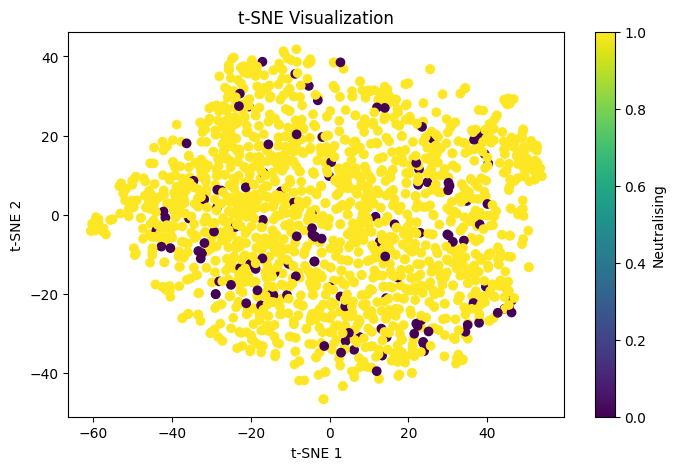

In [506]:
# Perform t-SNE (alternative to PCA)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(seqcodings2)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['neutralising'], cmap='viridis')
plt.colorbar(label='Neutralising')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization')
plt.show()

# Modeling Strategy 
For binary classification tasks, initiating the modeling process with a simple logistic regression model before progressing to more complex architectures like neural networks (NN) or fully connected (FC) models is a practical approach.

Here’s an expanded view on developing a robust machine learning model, incorporating both simple and complex methodologies:

- Initial Simple Model: Starting with logistic regression is beneficial due to its simplicity, interpretability, and efficiency in training. This step allows for a preliminary assessment of the dataset's characteristics and the feasibility of achieving meaningful classification.
- Progression to Complex Models: After evaluating the performance of the logistic regression model, transitioning to a neural network or a fully connected model can offer deeper insights and potentially improved accuracy. These complex models are capable of capturing nonlinear relationships and interactions within the data.

When developing these models, consider several important factors:

Data Imbalance: Acknowledge the presence of data imbalance and its potential effects on model performance.
Balancing the Dataset: Employ appropriate techniques to balance the dataset, such as resampling methods, to ensure equitable representation of classes.
Balancing the Dataset: Employ appropriate techniques to balance the dataset, such as resampling methods, to ensure equitable representation of classes.
Data Division: Strategically divide the data into training, validation, and testing sets. Utilize the training and validation sets for fine-tuning the hyperparameters of the models.


In [507]:
# Set the random seeds for numpy and tensorflow to ensure reproducible results
np.random.seed(42)
tf.random.set_seed(42)

In [508]:
# This split ensures balanced classes in the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    seqcodings, neutralising, test_size=0.1, random_state=0, stratify=neutralising
)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    seqcodings2, neutralising, test_size=0.1, random_state=0, stratify=neutralising
)

In [509]:
# Standardize the dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Standardize the dataset
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)
X_train2 = np.array(X_train2)
X_test2 = np.array(X_test2)
y_train2 = np.array(y_train2)
y_test2 = np.array(y_test2)

### logistic Regression model 

In [510]:
# Initialize an empty DataFrame to store simplified metrics
metrics_df = pd.DataFrame(columns=['Model','Accuracy', 'f1_Score'])

In [511]:
# # Create and train the Logistic Regression model
# model = LogisticRegression(max_iter=1000, C=1.0)
# model.fit(X_train, y_train)

# # Predict the labels for the test set
# y_pred = model.predict(X_test)

# # # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
# new_row = {'Model': 'LogisticRegression', 'Accuracy': accuracy, 'f1_Score': f1}
# new_row_df = pd.DataFrame([new_row])
# metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
# print(f'Accuracy: {accuracy}')
# print(f'f1_score: {f1}')
# print(classification_report(y_test, y_pred))

In [512]:
metrics_df

,Model,Accuracy,f1_Score


### A NN model 

In [513]:
# set parameters:
n_epochs = 20
batch_size = 50

In [514]:
# Defining an Artificial Neural Network (ANN) model, using tensorflow keras
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
ann2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [515]:
# Training the ANN on the Training set
history = ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
history2 = ann2.fit(X_train2, y_train2, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5793 - loss: 0.6073 - val_accuracy: 0.8557 - val_loss: 0.4770
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8849 - loss: 0.4453 - val_accuracy: 0.9180 - val_loss: 0.3543
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9171 - loss: 0.3263 - val_accuracy: 0.9180 - val_loss: 0.2780
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9218 - loss: 0.2627 - val_accuracy: 0.9180 - val_loss: 0.2617
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9218 - loss: 0.2356 - val_accuracy: 0.9213 - val_loss: 0.2599
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9218 - loss: 0.2219 - val_accuracy: 0.9246 - val_loss: 0.2613
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9213 - loss: 0.2099 - val_accuracy: 0.9246 - val_loss: 0.2650
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9237 - loss: 0.2000 - val_accuracy: 0.9279 - val_loss:

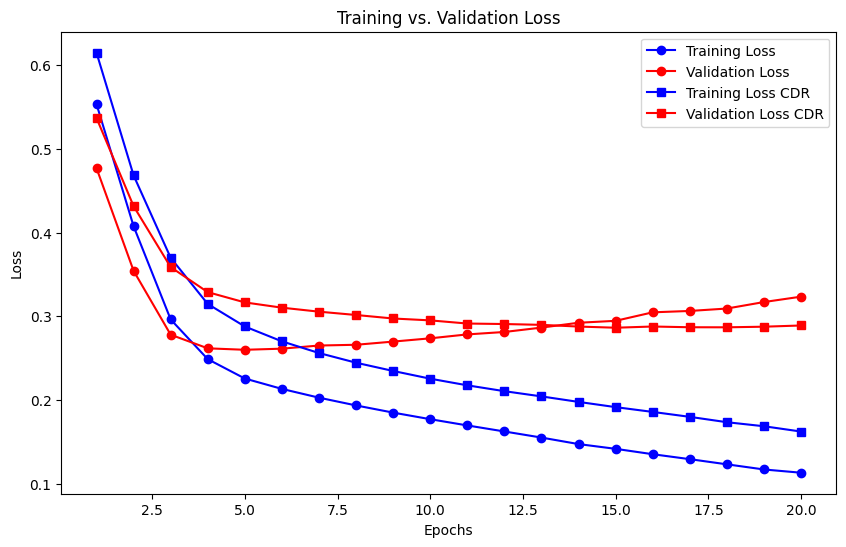

In [516]:
# Extracting loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_loss2 = history2.history['loss']
validation_loss2 = history2.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.plot(epochs, training_loss2, 'bs-', label='Training Loss CDR')
plt.plot(epochs, validation_loss2, 'rs-', label='Validation Loss CDR')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### How should we interpert this plot?

1. Training Loss vs. Validation Loss:
- The training loss measures how well the model is fitting the training data. As the training progresses (more epochs), the model learns and the training loss typically decreases.
- The validation loss measures how well the model performs on a separate set of data not seen during training, giving an indication of how well the model generalizes.

2. Interpretation of the Loss Trends:
- Initially, both training and validation losses decrease, which is good—it means the model is learning and generalizing well.
- However, after a certain number of epochs, the validation loss stops decreasing and starts to fluctuate or even increase slightly while the training loss continues to decrease. This is a classic sign of overfitting.

3. Overfitting:
- Overfitting occurs when the model learns the training data too well, including noise and details that do not generalize to new data. It's like memorizing the answers instead of understanding the subject.
- In the plot, overfitting is suggested because the model's loss on the validation set is no longer decreasing alongside the training loss. The model is improving on the training data but not on the validation data.

### Improving the Model:
- Early Stopping: Implement early stopping to terminate the training process when the validation loss stops decreasing, preventing overfitting by not allowing the model to train excessively.
- Regularization: Introduce regularization methods like L1 or L2 regularization to constrain the magnitude of the model weights, which can discourage overfitting by imposing complexity penalties on the model's loss function.
- Dropout: Add dropout layers to the neural network architecture to introduce regularization by randomly setting a fraction of the input units to 0 at each update during training, which can help prevent overfitting.
- Data Augmentation: Employ data augmentation techniques to synthetically expand the training dataset by applying random, yet realistic, transformations to the training data. This can lead to a model that generalizes better.
- Reduce Model Complexity: Simplify the model's architecture by reducing the number of layers or the number of neurons in each layer if the model is too complicated and overfitting the training data.
- Adjust Learning Rate and Batch Size: Fine-tune the learning rate and batch size to control the training dynamics. A learning rate that's too high can cause the model to converge too quickly to suboptimal solutions, whereas one that's too low can slow down the training process. Similarly, an appropriate batch size can balance between computational efficiency and the regularizing effect of stochasticity in the gradient descent.
- Perform Hyperparameter Tuning: Run systematic experiments to find the best model parameters, including the learning rate, batch size, and other model-specific hyperparameters. This can be done using techniques like grid search or random search, or more sophisticated methods like Bayesian optimization. By tuning hyperparameters, you can potentially improve the model's performance and robustness.
    
For beginners, it's important to monitor both training and validation loss and look for signs of overfitting. Interventions like those mentioned above can help ensure that your model learns to generalize well, rather than just memorizing the training dataset.

In [517]:
# Predict the labels for the test set
predictions_prob = ann.predict(X_test) 
predictions_prob2 = ann2.predict(X_test2)

# Assuming `predictions` are the output probabilities from your model
y_pred = (predictions_prob > .5).astype(int)
y_pred2 = (predictions_prob2 > .5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_shallow', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)

accuracy = accuracy_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_shallow 2', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)

# print(f'Accuracy: {accuracy}')
# print(f'f1_score: {f1}')
# print(classification_report(y_test, y_pred))
metrics_df

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/tmp/ipykernel_2314831/1769065344.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)


,Model,Accuracy,f1_Score
0,nn_shallow,0.917160,0.956522
1,nn_shallow 2,0.923077,0.960000


The original model is a simple neural network with two hidden layers, each consisting of 6 units. This design may be too simplistic, especially if the input dimensionality is high (e.g., 480 features). With only 6 units in each layer, the model may not have enough capacity to learn complex patterns in the data, which could lead to underfitting.

Increased Layer Units:
- The proposed model begins with a significantly larger number of units (240) in the first hidden layer. Starting with more units can help the model capture a wide variety of patterns and relationships in the data, given the high dimensionality of the inputs.
-mGradually decreasing the number of units in subsequent layers (from 240 to 120, then 60, and finally 30) before reaching the output layer allows the model to refine and distill these patterns into more abstract representations. This approach is akin to funneling the information in a controlled manner, which can be particularly effective in learning from a large number of features.

Regularization:
- Regularization is applied to each layer in the form of L2 regularization with a factor of 0.01. L2 regularization penalizes the weights' magnitudes by adding a term to the loss function proportional to the sum of the squared weights. This encourages the model to keep the weights small, which can help prevent overfitting by discouraging the model from relying too heavily on any single feature or combination of features.
- Regularization can be crucial when increasing the number of units in the layers as it helps to maintain the generalization ability of the model despite the added complexity.

Learning rate:
- Adjusting the learning rate to 0.001 for better performance. A smaller learning rate can make the optimization process more gradual and precise, potentially leading to better convergence on a minimum of the loss function.


While the proposed model has the potential to learn complex patterns better, it is also more prone to overfitting due to its increased capacity. Therefore, it is essential to monitor the model's performance on both training and validation datasets and consider implementing additional strategies such as dropout, early stopping, or further hyperparameter tuning to find the optimal model configuration.

In [518]:
# Define the model architecture
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define the model architecture
ann2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann2.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [519]:
# Training the ANN on the Training set
history = ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
history = ann2.fit(X_train2, y_train2, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9218 - loss: 5.7321 - val_accuracy: 0.9213 - val_loss: 4.1411
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9217 - loss: 3.6792 - val_accuracy: 0.9213 - val_loss: 2.6618
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9242 - loss: 2.3335 - val_accuracy: 0.9180 - val_loss: 1.7578
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9311 - loss: 1.5126 - val_accuracy: 0.9213 - val_loss: 1.2216
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9376 - loss: 1.0221 - val_accuracy: 0.9180 - val_loss: 0.9108
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9527 - loss: 0.7292 - val_accuracy: 0.9115 - val_loss: 0.7251
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9560 - loss: 0.5489 - val_accuracy: 0.9213 - val_loss: 0.6045
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9621 - loss: 0.4402 - val_accuracy: 0.9115 - val_loss

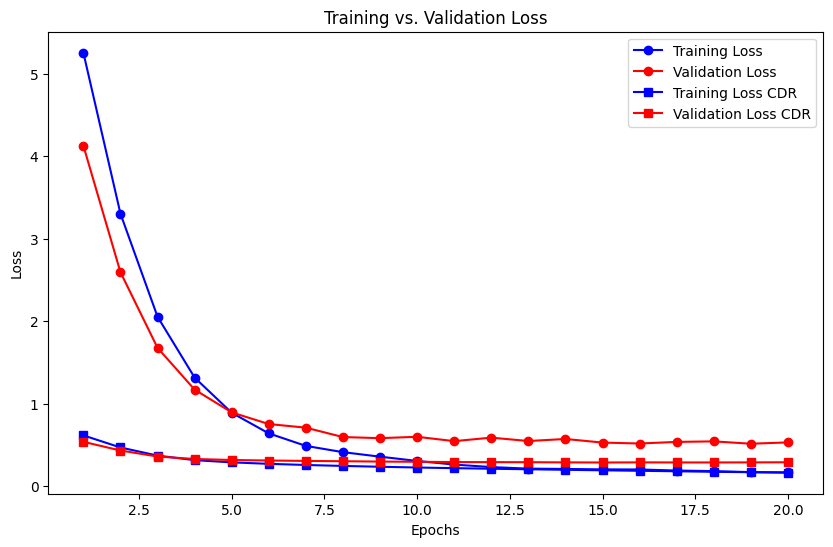

In [520]:
# Extracting loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_loss2 = history2.history['loss']
validation_loss2 = history2.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.plot(epochs, training_loss2, 'bs-', label='Training Loss CDR')
plt.plot(epochs, validation_loss2, 'rs-', label='Validation Loss CDR')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [521]:
# Predict the labels for the test set
predictions_prob = ann.predict(X_test)
predictions_prob2 = ann2.predict(X_test2)

# Assuming `predictions` are the output probabilities from your model
y_pred = (predictions_prob > .5).astype(int)
y_pred2 = (predictions_prob2 > .5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_deep', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)

accuracy = accuracy_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_deep 2', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
# print(f'Accuracy: {accuracy}')
# print(f'f1_score: {f1}')
# print(classification_report(y_test, y_pred))
metrics_df

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


,Model,Accuracy,f1_Score
0,nn_shallow,0.917160,0.956522
1,nn_shallow 2,0.923077,0.960000
2,nn_deep,0.917160,0.956250
3,nn_deep 2,0.946746,0.971429


### balancing data using weight adjustment 

In [522]:
# let's improve the model by adjusting the weight of low sample data.
# Calculate class weights
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

weights2 = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train2),
    y=y_train2
)
class_weights2 = dict(enumerate(weights2))

In [523]:
class_weights2

{0: 6.790178571428571, 1: 0.5397444996451384}

In [524]:
# Define the model architecture
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Define the model architecture
ann2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# Compiling the ANN
ann2.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [525]:
# Training the ANN on the Training set with class weight adjustment
history = ann.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, class_weight=class_weights)
history = ann2.fit(X_train2, y_train2, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, class_weight=class_weights2)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5178 - loss: 6.3009 - val_accuracy: 0.4230 - val_loss: 5.2777
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6565 - loss: 4.7764 - val_accuracy: 0.5574 - val_loss: 4.0862
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7115 - loss: 3.6582 - val_accuracy: 0.6098 - val_loss: 3.2289
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7849 - loss: 2.8217 - val_accuracy: 0.7016 - val_loss: 2.6115
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8532 - loss: 2.2132 - val_accuracy: 0.7344 - val_loss: 2.1848
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8998 - loss: 1.7493 - val_accuracy: 0.7967 - val_loss: 1.7840
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9126 - loss: 1.4628 - val_accuracy: 0.6262 - val_loss: 1.9726
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7868 - loss: 1.4133 - val_accuracy: 0.7180 - val_loss

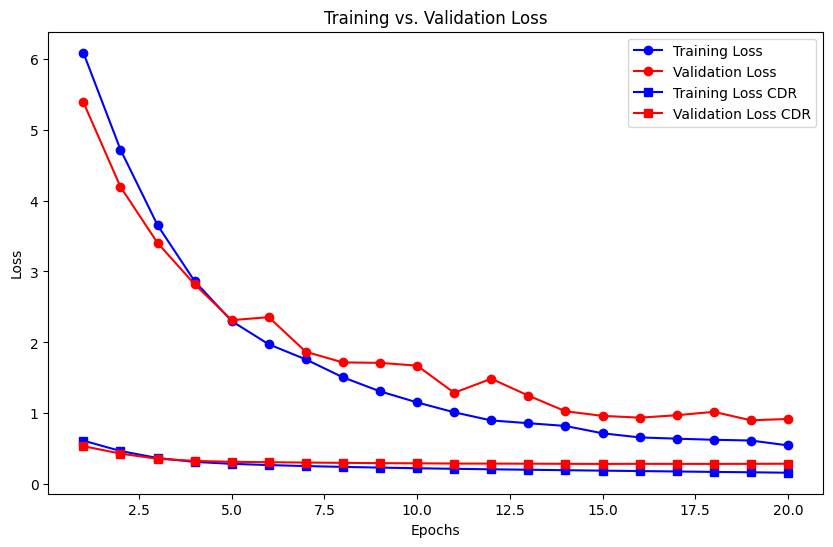

In [526]:
# Extracting loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_loss2 = history2.history['loss']
validation_loss2 = history2.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.plot(epochs, training_loss2, 'bs-', label='Training Loss CDR')
plt.plot(epochs, validation_loss2, 'rs-', label='Validation Loss CDR')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [527]:
# Predict the labels for the test set
predictions_prob = ann.predict(X_test)
predictions_prob2 = ann2.predict(X_test2)

# Assuming `predictions` are the output probabilities from your model
y_pred = (predictions_prob > .5).astype(int)
y_pred2 = (predictions_prob2 > .5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_deep_weighted', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)

accuracy = accuracy_score(y_test2, y_pred2)
f1 = f1_score(y_test2, y_pred2, average='binary')  # Ensure average='binary' for binary classification
new_row = {'Model': 'nn_deep_weighted 2', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
# print(f'Accuracy: {accuracy}')
# print(f'f1_score: {f1}')
# print(classification_report(y_test, y_pred))
metrics_df

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


,Model,Accuracy,f1_Score
0,nn_shallow,0.917160,0.956522
1,nn_shallow 2,0.923077,0.960000
2,nn_deep,0.917160,0.956250
3,nn_deep 2,0.946746,0.971429
4,nn_deep_weighted,0.893491,0.941558
5,nn_deep_weighted 2,0.881657,0.934641


In [528]:
# Define the K-fold cross validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Lists to store results of each fold
all_y_test = []
all_y_pred = []

# K-fold Cross Validation model evaluation
fold_no = 1
X= X_train
y = y_train
for train, test in kfold.split(X, y):

    # Define the model architecture
    ann = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    ann.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
  
    # Fit the model
    print(f'Training for fold {fold_no} ...')
    ann.fit(X[train], y[train], batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X[test], y[test]))
    
    # Generate predictions
    y_pred = ann.predict(X[test])
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Store the true labels and predictions
    all_y_test.extend(y[test])
    all_y_pred.extend(y_pred_binary.flatten())  # Flatten to ensure it's a 1D array

    # Increase fold number
    fold_no += 1

Training for fold 1 ...
Epoch 1/20


/opt/jupyterhub/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8417 - loss: 5.9555 - val_accuracy: 0.9049 - val_loss: 4.4692
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9225 - loss: 3.9899 - val_accuracy: 0.9049 - val_loss: 2.9697
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9225 - loss: 2.6085 - val_accuracy: 0.9049 - val_loss: 2.0139
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9271 - loss: 1.7260 - val_accuracy: 0.9049 - val_loss: 1.4352
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9317 - loss: 1.1846 - val_accuracy: 0.9082 - val_loss: 1.0875
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9448 - loss: 0.8493 - val_accuracy: 0.9148 - val_loss: 0.8850
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9571 - loss: 0.6451 - val_accuracy: 0.9115 - val_loss: 0.7524
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9545 - loss: 0.5187 - val_accuracy: 0.9148 - val_loss: 0.6680
Ep

In [529]:
# Performance assessment
# Now, all_y_test and all_y_pred contain all the test labels and predictions across all folds
print('Overall performance:')
# Evaluate the model
accuracy = accuracy_score(all_y_test, all_y_pred)
f1 = f1_score(all_y_test, all_y_pred, average='binary')  
new_row = {'Model': 'nn_deep_weighted_5fold', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
print(f'Accuracy: {accuracy}')
print(f'f1_score: {f1}')
print(classification_report(all_y_test, all_y_pred))
metrics_df

Overall performance:
Accuracy: 0.8724523339907956
f1_score: 0.9307142857142857
              precision    recall  f1-score   support

           0       0.18      0.21      0.20       112
           1       0.94      0.92      0.93      1409

    accuracy                           0.87      1521
   macro avg       0.56      0.57      0.56      1521
weighted avg       0.88      0.87      0.88      1521



,Model,Accuracy,f1_Score
0,nn_shallow,0.917160,0.956522
1,nn_shallow 2,0.923077,0.960000
2,nn_deep,0.917160,0.956250
3,nn_deep 2,0.946746,0.971429
4,nn_deep_weighted,0.893491,0.941558
5,nn_deep_weighted 2,0.881657,0.934641
6,nn_deep_weighted_5fold,0.872452,0.930714


In [530]:
# Define the K-fold cross validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Lists to store results of each fold
all_y_test2 = []
all_y_pred2 = []

# K-fold Cross Validation model evaluation
fold_no = 1
X= X_train2
y = y_train2
for train, test in kfold.split(X, y):

    # Define the model architecture
    ann2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=240, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(units=120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    ann2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
  
    # Fit the model
    print(f'Training for fold {fold_no} ...')
    ann2.fit(X[train], y[train], batch_size=batch_size, epochs=n_epochs, verbose=1, validation_data=(X[test], y[test]))
    
    # Generate predictions
    y_pred2 = ann2.predict(X[test])
    y_pred_binary2 = (y_pred2 > 0.5).astype(int)
    
    # Store the true labels and predictions
    all_y_test2.extend(y[test])
    all_y_pred2.extend(y_pred_binary2.flatten())  # Flatten to ensure it's a 1D array

    # Increase fold number
    fold_no += 1

Training for fold 1 ...
Epoch 1/20


/opt/jupyterhub/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7776 - loss: 6.0625 - val_accuracy: 0.9508 - val_loss: 4.4859
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9270 - loss: 4.0746 - val_accuracy: 0.9508 - val_loss: 2.9666
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9270 - loss: 2.6761 - val_accuracy: 0.9508 - val_loss: 1.9845
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9278 - loss: 1.7775 - val_accuracy: 0.9508 - val_loss: 1.3927
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9362 - loss: 1.2237 - val_accuracy: 0.9541 - val_loss: 1.0444
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9465 - loss: 0.8841 - val_accuracy: 0.9377 - val_loss: 0.8393
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9579 - loss: 0.6730 - val_accuracy: 0.9410 - val_loss: 0.7137
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9635 - loss: 0.5340 - val_accuracy: 0.9311 - val_loss: 0.6396
Ep

In [531]:
# Performance assessment
# Now, all_y_test and all_y_pred contain all the test labels and predictions across all folds
print('Overall performance:')
# Evaluate the model
accuracy = accuracy_score(all_y_test2, all_y_pred2)
f1 = f1_score(all_y_test2, all_y_pred2, average='binary')  
new_row = {'Model': 'nn_deep_weighted_5fold 2', 'Accuracy': accuracy, 'f1_Score': f1}
new_row_df = pd.DataFrame([new_row])
metrics_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
print(f'Accuracy: {accuracy}')
print(f'f1_score: {f1}')
print(classification_report(all_y_test2, all_y_pred2))
metrics_df

Overall performance:
Accuracy: 0.886259040105194
f1_score: 0.9392342817000351
              precision    recall  f1-score   support

           0       0.13      0.10      0.11       112
           1       0.93      0.95      0.94      1409

    accuracy                           0.89      1521
   macro avg       0.53      0.52      0.53      1521
weighted avg       0.87      0.89      0.88      1521



,Model,Accuracy,f1_Score
0,nn_shallow,0.917160,0.956522
1,nn_shallow 2,0.923077,0.960000
2,nn_deep,0.917160,0.956250
3,nn_deep 2,0.946746,0.971429
4,nn_deep_weighted,0.893491,0.941558
5,nn_deep_weighted 2,0.881657,0.934641
6,nn_deep_weighted_5fold,0.872452,0.930714
7,nn_deep_weighted_5fold 2,0.886259,0.939234


In [435]:
# show 3D structure
offset = int(7500 * 0.8)
matchCnt = sum([1 for pred, test in zip(y_pred, y_test) if pred == test])
totalCnt = len(y_pred)

# Find the first non-empty pdbid and its sequence
# pdbid is currently empty
for i, pdbid in enumerate(pdbids[offset:], start=offset):
    if pdbid:  # Checks if pdbid is not empty
        seq = seqs[i]
        print(f"PDB ID: {pdbid}, seq: {seq}")

        idStr = f'mmdbid={pdbid}'
        # Ensure seq is a string for concatenation
        seqStr = ''.join(seq) if isinstance(seq, list) else seq
        cmdStr = f'select :{seqStr} | name test; color F00; style proteins sphere'
        view = icn3dpy.view(q=idStr, command=cmdStr)
        view
        break  # Exit the loop after the first match

print(f"totalCnt: {totalCnt}, matchCnt: {matchCnt}, Matched ratio: {matchCnt/totalCnt}")


totalCnt: 1359, matchCnt: 0, Matched ratio: 0.0


In [119]:
idStr = 'mmdbid=' + pdbid
cmdStr = 'select :' + seqStr + ' | name test; color F00; style proteins sphere'
print (idStr, cmdStr)

NameError: name 'seqStr' is not defined

In [120]:
view = icn3dpy.view(q=idStr,command=cmdStr)
view

NameError: name 'icn3dpy' is not defined

# Optional

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


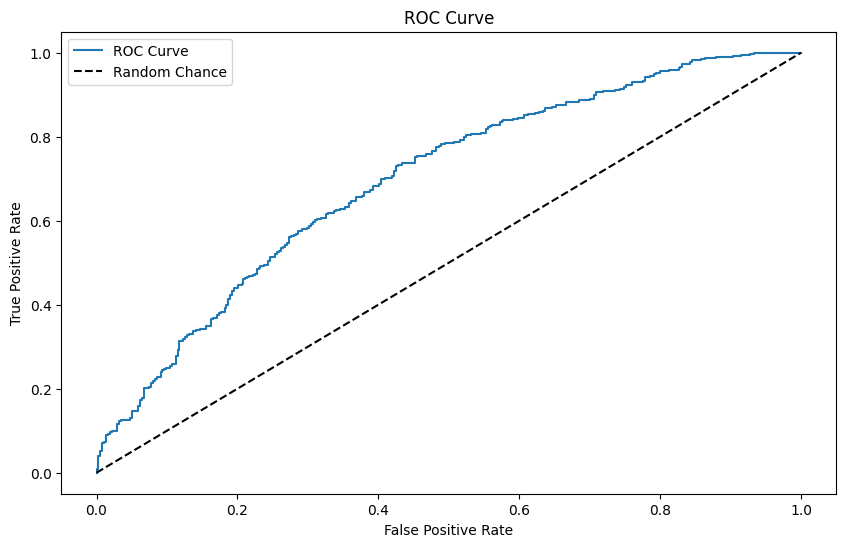

In [121]:
# let dig more into the results:
from sklearn.metrics import roc_curve
y_probs = ann.predict(X_test)
# Calculate FPR, TPR, and thresholds for the ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
import matplotlib.pyplot as plt

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

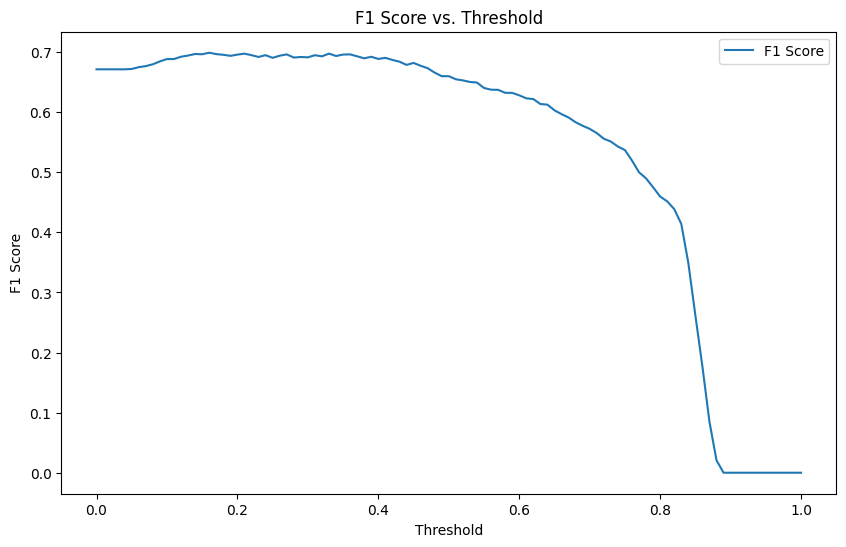

In [122]:
# Define a range of thresholds to evaluate
thresholds = np.linspace(0, 1, 101)

# Calculate F1 scores for each threshold
f1_scores = [f1_score(y_test, y_probs > threshold) for threshold in thresholds]

# Plotting F1 scores against thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend(loc='best')
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


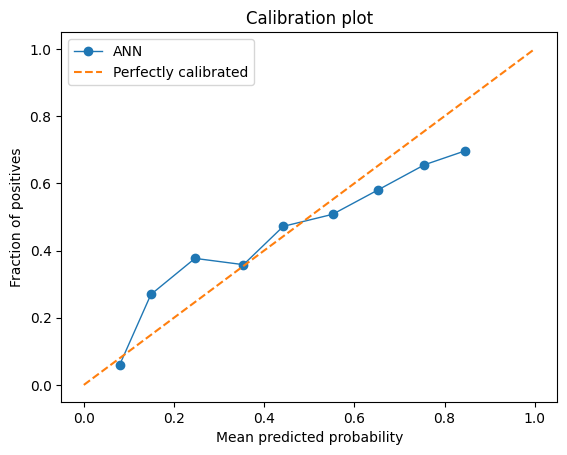

In [123]:
# let find the optimal threshold for balancing false positives and false negatives 
# to do that we are using calibration plot.
# Step 1: we should predict the probablities
y_probs = ann.predict(X_test)
# Step 2: Calculate Precision, Recall, and Thresholds
from sklearn.metrics import precision_recall_curve
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# Step 3: Create a Calibration Plot

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

# Plotting the calibration curve
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='ANN')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot')
plt.legend()
plt.show()